In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
# параметры распределений
mu00, mu01, sigma00, sigma01 = -2., -2., 1., 1.
mu10, mu11, sigma10, sigma11 =  3., 3., 2., 2.

In [3]:
# размерность точек
num_x = 500
num_y = 500

In [4]:
d00 = torch.distributions.multivariate_normal.MultivariateNormal(
    torch.tensor([mu00, 
                  mu01]),
    torch.tensor([[sigma00, 0], 
                  [0, sigma01]]))
d10 = torch.distributions.multivariate_normal.MultivariateNormal(
    torch.tensor([mu10, 
                  mu11]), 
    torch.tensor([[sigma10, 0], 
                  [0, sigma11]]))
d00.sample((5,))

tensor([[-1.9265, -2.3546],
        [-2.2754, -2.8149],
        [-2.1565, -1.4299],
        [-1.3519, -2.3481],
        [-0.4525, -3.0137]])

In [5]:
d00.sample((5,)).shape

torch.Size([5, 2])

<function matplotlib.pyplot.show(*args, **kw)>

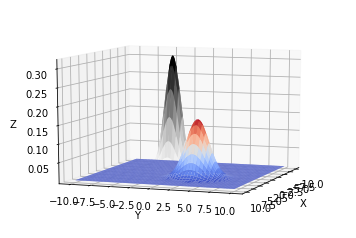

In [6]:
from matplotlib import cm

# plot 3d Probability density function
fig = plt.figure()
# ax = Axes3D(fig)
ax = fig.gca(projection='3d')
x_scale = np.linspace(-10, 10, num_x)
y_scale = np.linspace(-10, 10, num_y)
X, Y = np.meshgrid(x_scale, y_scale)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv0 = stats.multivariate_normal([mu00, mu01], [[sigma00, 0], [0, sigma01]])
Z0 = rv0.pdf(pos)
rv1 = stats.multivariate_normal([mu10, mu11], [[sigma10, 0], [0, sigma11]])
Z1 = rv1.pdf(pos)

ax.plot_surface(X, Y, Z0*2, cmap=cm.Greys)
ax.plot_surface(X, Y, Z1*2, cmap=cm.coolwarm)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(10, 20)
ratio = Z1 / (Z0 + Z1)

plt.show

In [7]:
x_tensor = torch.tensor(pos, dtype=torch.float)

In [8]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [9]:
net = nn.Sequential(nn.Linear(2, 5), nn.ReLU(), nn.Linear(5, 1))
for p in net.parameters():
    print(p.data)
net_opt = optim.SGD(lr=1e-3, params=list(net.parameters()))

tensor([[ 0.3503, -0.1608],
        [ 0.2621, -0.6928],
        [ 0.0082, -0.4225],
        [-0.3437, -0.4049],
        [ 0.1652, -0.4613]])
tensor([-0.4491, -0.2164,  0.0890, -0.3275, -0.2205])
tensor([[ 0.0203,  0.2610, -0.3959,  0.1476, -0.2131]])
tensor([-0.4399])


In [10]:
with torch.no_grad():
    dist = F.sigmoid(net(x_tensor)).numpy()
dist.shape

(500, 500, 1)

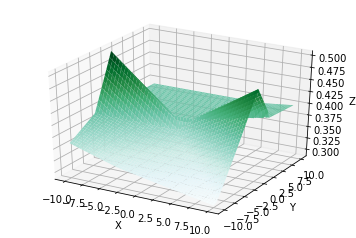

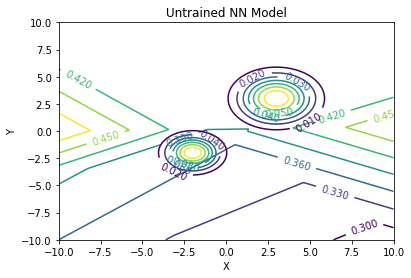

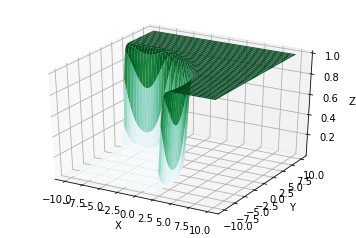

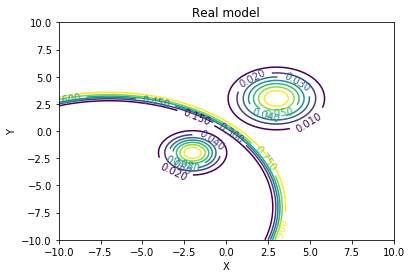

In [11]:
# visualisation
Z = dist.flatten().reshape(num_x, num_y)
fig = plt.figure()
# ax = Axes3D(fig)
ax = fig.gca(projection='3d')
x_scale = np.linspace(-10, 10, num_x)
y_scale = np.linspace(-10, 10, num_y)
X, Y = np.meshgrid(x_scale, y_scale)
ax.plot_surface(X, Y, Z, cmap=cm.BuGn)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.figure()
CS = plt.contour(X, Y, Z)
CS1 = plt.contour(X, Y, Z0)
CS2 = plt.contour(X, Y, Z1)
plt.clabel(CS, inline=1, fontsize=10)
plt.clabel(CS1, inline=1, fontsize=10)
plt.clabel(CS2, inline=1, fontsize=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Untrained NN Model')

fig = plt.figure()
# ax = Axes3D(fig)
ax = fig.gca(projection='3d')
x_scale = np.linspace(-10, 10, num_x)
y_scale = np.linspace(-10, 10, num_y)
X, Y = np.meshgrid(x_scale, y_scale)
ax.plot_surface(X, Y, ratio, cmap=cm.BuGn)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Z = ratio
plt.figure()
CS = plt.contour(X, Y, Z)
CS1 = plt.contour(X, Y, Z0)
CS2 = plt.contour(X, Y, Z1)
plt.clabel(CS, inline=1, fontsize=10)
plt.clabel(CS1, inline=1, fontsize=10)
plt.clabel(CS2, inline=1, fontsize=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Real model');


In [12]:
log_freq = 500
for i in range(20000):
    if i % log_freq == 0:
        with torch.no_grad():
            x, y = sample(d00, d10, 100000)
            out = F.sigmoid(net(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' % (i / log_freq, loss))
    net_opt.zero_grad()
    x, y = sample(d00, d10, 1024)
    
    out = net(x)
    loss = F.binary_cross_entropy_with_logits(out, y)
    
    loss.backward()
    net_opt.step()

Ошибка после 0 итераций: 0.696612
Ошибка после 1 итераций: 0.611620
Ошибка после 2 итераций: 0.539921
Ошибка после 3 итераций: 0.466109
Ошибка после 4 итераций: 0.375093
Ошибка после 5 итераций: 0.272305
Ошибка после 6 итераций: 0.188811
Ошибка после 7 итераций: 0.135630
Ошибка после 8 итераций: 0.104205
Ошибка после 9 итераций: 0.083932
Ошибка после 10 итераций: 0.070097
Ошибка после 11 итераций: 0.060009
Ошибка после 12 итераций: 0.052504
Ошибка после 13 итераций: 0.047232
Ошибка после 14 итераций: 0.042401
Ошибка после 15 итераций: 0.038567
Ошибка после 16 итераций: 0.035527
Ошибка после 17 итераций: 0.033054
Ошибка после 18 итераций: 0.030679
Ошибка после 19 итераций: 0.029077
Ошибка после 20 итераций: 0.027593
Ошибка после 21 итераций: 0.025637
Ошибка после 22 итераций: 0.024623
Ошибка после 23 итераций: 0.023470
Ошибка после 24 итераций: 0.022687
Ошибка после 25 итераций: 0.021598
Ошибка после 26 итераций: 0.020876
Ошибка после 27 итераций: 0.020030
Ошибка после 28 итераций: 0.01

In [13]:

with torch.no_grad():
    dist = F.sigmoid(net(x_tensor)).numpy()
dist.shape

(500, 500, 1)

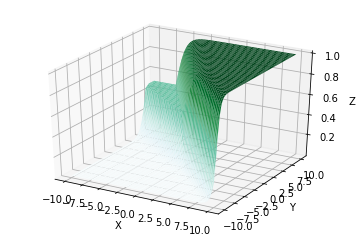

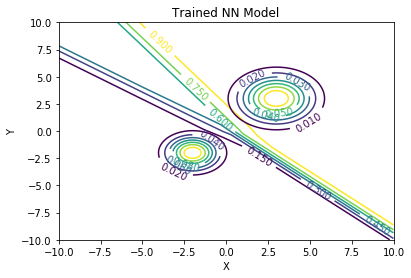

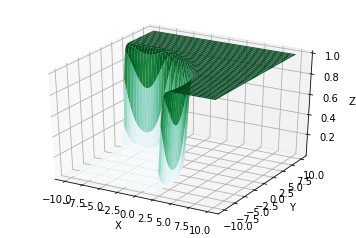

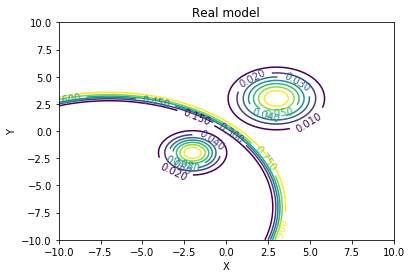

In [14]:
# visualisation
Z = dist.flatten().reshape(num_x, num_y)
fig = plt.figure()
# ax = Axes3D(fig)
ax = fig.gca(projection='3d')
x_scale = np.linspace(-10, 10, num_x)
y_scale = np.linspace(-10, 10, num_y)
X, Y = np.meshgrid(x_scale, y_scale)
ax.plot_surface(X, Y, Z, cmap=cm.BuGn)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.figure()
CS = plt.contour(X, Y, Z)
CS1 = plt.contour(X, Y, Z0)
CS2 = plt.contour(X, Y, Z1)
plt.clabel(CS, inline=1, fontsize=10)
plt.clabel(CS1, inline=1, fontsize=10)
plt.clabel(CS2, inline=1, fontsize=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trained NN Model')

fig = plt.figure()
# ax = Axes3D(fig)
ax = fig.gca(projection='3d')
x_scale = np.linspace(-10, 10, num_x)
y_scale = np.linspace(-10, 10, num_y)
X, Y = np.meshgrid(x_scale, y_scale)
ax.plot_surface(X, Y, ratio, cmap=cm.BuGn)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Z = ratio
plt.figure()
CS = plt.contour(X, Y, Z)
CS1 = plt.contour(X, Y, Z0)
CS2 = plt.contour(X, Y, Z1)
plt.clabel(CS, inline=1, fontsize=10)
plt.clabel(CS1, inline=1, fontsize=10)
plt.clabel(CS2, inline=1, fontsize=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Real model');
